# Analysis Notebook for BenchExec Experiments

This notebook pre-processes the results obtained from Benchexec and plots it using seaborn.

In [2]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import dtale

# sys.dont_write_bytecode = True  # prevent creation of .pyc files

CSV_FOLDER = "results/"

## 1. Load data from CSV

Collect all CSV result files under `CSV_FOLDER` folder.

In [3]:
print(f"CSV files found in folder {CSV_FOLDER}:")
files = glob.glob(os.path.join(CSV_FOLDER, "results.*.csv"))

files

CSV files found in folder results/:


['results/results.2025-03-11_08-28-18.table-PR2.csv',
 'results/results.2025-03-11_08-28-36.table-PRP.csv',
 'results/results.2024-05-06_10-42-28.table-LPG.csv']

Load all CSV data into a single dataframe. Note that each CSV file may include results for many _run sets_, with each having its own columns. 

Each row is the result of a _task_ in the experiment, and every run set has its columns stats for such task. We then need to reshape this and just have one set of columns and the run set be another new column.

The first three lines contain header:

1. First line contains the _tool_ used. It starts with `tool` followed by the name of the tool repeated multiple times (to match no. of columns).
2. Second line contains the _runs_ of the experiment. It starts with `run set` and then sets of columns with the name of the runs.
3. Third line contains the _stats_ column names repeated per run set. First column is for name of the task.

An example with two runs `lpg` and `lpg_small`, using tool `PP-LPG`, is as follows:

```csv
tool	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 	PP-LPG 
run set	lpg	lpg	lpg	lpg	lpg	lpg	lpg	lpg_small	lpg_small	lpg_small	lpg_small	lpg_small	lpg_small	lpg_small
/home/nitin/app/benchmarks/benchexe/tasks/	status	cputime (s)	walltime (s)	memory (MB)	policy_size	solve_time	translation_time	status	cputime (s)	walltime (s)	memory (MB)	policy_size	solve_time	translation_time
AIJ_Barman_EIGHT50_1.yml	true	185.430462	185.5002005007118	295.952384	4966	185.0386784542352	0.263661066070199	true	16.422719	16.462604857981205	273.047552	4501	16.02331303898245	0.26572485268116
AIJ_Barman_EIGHT50_10.yml	true	94.405856	94.43696516938508	288.591872	5200	93.96452420670539	0.28180090803653	true	27.34709	27.380704921670258	276.148224	3846	26.93289530556649	0.26796702668070793
AIJ_Barman_EIGHT50_11.yml	false	1799.112512	1799.4882240109146	430.522368		-1	0.2723603779450059	true	550.644056	550.7977258479223	437.944320	48991	550.3052532738075	0.2680810196325183
AIJ_Barman_EIGHT50_12.yml	false	1799.168697	1799.4754690360278	457.166848		-1	0.2691544583067298	true	554.876223	555.0061234645545	416.649216	52499	554.5180832231417	0.2642196826636791
```




In [4]:
RENAME_COLS = {"benchmarks/benchexe/tasks/": "id", "cputime (s)": "cputime", "walltime (s)": "walltime", "memory (MB)": "memory_mb"}

def get_meta_csv(file):
    """Given a benchexec CSV file, extract the runs (e.g., prp, prp_inv) and how many columns per run"""
    with open(file, "r") as f:
        # first line contains the tool used (repeated one per column needed); e.g.,  PP-FOND
        tools_header = f.readline().split()[1:]
        # second line contains the run/solvers used in the experiment (e.g., prp, prp_inv) and starts with "run set" to be ignored
        runs_header = f.readline().split()[2:]
        
    runs = sorted(list(set(runs_header)))

    no_cols = int(len(runs_header) / len(runs))

    return runs, no_cols


dfs = []
for f in files:
    runs, no_cols = get_meta_csv(f)
    print(f"Runs in file {f}: {runs} with {no_cols} stat columns")

    # go over each set of run columns (a csv file may contain many runs, each with the same columns)
    for k, r in enumerate(list(runs)):
        col_idx = [0] + list(range(k*no_cols + 1, k*no_cols + no_cols + 1))
        print(f"\t Extracting run '{r}' in columns: {col_idx}")

        # read the CSV file from line 3+ (line 3 is header)
        df = pd.read_csv(f, delimiter="\t", skiprows=2, usecols=col_idx)
        df.rename(columns=lambda x: x.split('.')[0], inplace=True)

        df.columns.values[0] = "task"
        # df.rename(columns={df.columns[1]: "task"})

        # populate column run with name of run-solver r
        df.insert(1, 'run', r)
        dfs.append(df)

df_csv = pd.concat(dfs).reset_index(drop=True)

df_csv.rename(columns=RENAME_COLS, inplace=True)

# df.set_index("task", inplace=True)
df_csv

Runs in file results/results.2025-03-11_08-28-18.table-PR2.csv: ['pr2', 'pr2_inv0'] with 7 stat columns
	 Extracting run 'pr2' in columns: [0, 1, 2, 3, 4, 5, 6, 7]
	 Extracting run 'pr2_inv0' in columns: [0, 8, 9, 10, 11, 12, 13, 14]
Runs in file results/results.2025-03-11_08-28-36.table-PRP.csv: ['prp', 'prp_inv0'] with 7 stat columns
	 Extracting run 'prp' in columns: [0, 1, 2, 3, 4, 5, 6, 7]
	 Extracting run 'prp_inv0' in columns: [0, 8, 9, 10, 11, 12, 13, 14]
Runs in file results/results.2024-05-06_10-42-28.table-LPG.csv: ['lpg', 'lpg_small'] with 7 stat columns
	 Extracting run 'lpg' in columns: [0, 1, 2, 3, 4, 5, 6, 7]
	 Extracting run 'lpg_small' in columns: [0, 8, 9, 10, 11, 12, 13, 14]


,task,run,status,cputime,walltime,memory_mb,policy_size,solve_time,translation_time
0,AIJ_Barman_EIGHT50_1.yml,pr2,true,16.026175,16.066372,123.805696,1370.0,15.562511,0.303117
1,AIJ_Barman_EIGHT50_10.yml,pr2,true,15.246974,15.289514,112.234496,3672.0,14.780735,0.306904
2,AIJ_Barman_EIGHT50_11.yml,pr2,true,68.218810,68.266702,121.892864,19793.0,67.748034,0.316544
3,AIJ_Barman_EIGHT50_12.yml,pr2,true,104.457013,104.491214,142.397440,23262.0,103.991306,0.297826
4,AIJ_Barman_EIGHT50_13.yml,pr2,true,114.354010,114.391022,159.453184,31096.0,113.890758,0.301574
...,...,...,...,...,...,...,...,...,...
9075,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,False,1503.706185,1504.462974,413.261824,NaN,-1.000000,0.267817
9076,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,False,856.388705,856.663302,404.643840,NaN,-1.000000,0.258033
9077,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,True,1.128989,1.135885,263.499776,80.0,0.731003,0.232030
9078,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,True,1.435017,1.443103,264.585216,115.0,1.027600,0.241950


Test of the data is loaded correctly by printing a details of a task

In [5]:
task = "AIJ_BlocksWorld_EIGHT4-51_37.yml"
df_csv.query(f"task==@task")

,task,run,status,cputime,walltime,memory_mb,policy_size,solve_time,translation_time
89,AIJ_BlocksWorld_EIGHT4-51_37.yml,pr2,true,60.591840,60.604468,457.121792,227.0,60.101882,0.298300
1700,AIJ_BlocksWorld_EIGHT4-51_37.yml,pr2_inv0,true,0.901661,0.909400,39.383040,227.0,0.435348,0.282082
3311,AIJ_BlocksWorld_EIGHT4-51_37.yml,prp,true,14.369311,14.393623,255.922176,261.0,13.937154,0.277982
4922,AIJ_BlocksWorld_EIGHT4-51_37.yml,prp_inv0,true,0.769986,0.789696,33.984512,261.0,0.345376,0.268413
6533,AIJ_BlocksWorld_EIGHT4-51_37.yml,lpg,True,72.757916,72.773042,300.249088,122.0,72.352723,0.244429
7851,AIJ_BlocksWorld_EIGHT4-51_37.yml,lpg_small,True,5.259645,5.271215,269.611008,128.0,4.826468,0.251347


We enrich the dataframe with derived columns:
- source, instance, and domain extraced from the task
- convert `status` to boolean

In [6]:
def get_benchmark_labels(str):
    tokens = str.split("_")
    source = tokens[0]
    instance = tokens[-1][0:-4]
    domain = tokens[1]
    if len(tokens) > 3:
        sub_domain = tokens[2]
    else:
        sub_domain = ""
    if source == "SOCS":
        domain_tokens = domain.split("-")
        domain = domain_tokens[0]
    return source, domain, sub_domain, instance
    
# if "prp" in csv_file:
#     df["status"] = np.where(df["status"]=='true', True, False)

df = df_csv.copy()


# convert status column to just string: 'true', 'false', 'OUT OF MEMORY (false)', 'TIMEOUT (false)'
df['status'] = df['status'].replace({True: 'true', False: 'false'})

# next, define Boolean column solved to flag if solved or not based on status
df.insert(3, "solved", df['status'].apply(lambda x: True if x == "true" else False))

# split task into domains
df["benchmark"] = df.reset_index()["task"].map(get_benchmark_labels).values
df["set"] = df["benchmark"].str.get(0)
df["domain"] = df["benchmark"].str.get(1)
df["sub_domain"] = df["benchmark"].str.get(2)
df['full_domain'] = df['domain'] + "-" + df["sub_domain"]
df["instance"] = df["benchmark"].str.get(3)
# df.drop(columns=["benchmark"], inplace=True)

df.loc[df.status == "OUT OF MEMORY (false)"]
df

,task,run,status,solved,cputime,walltime,memory_mb,policy_size,solve_time,translation_time,benchmark,set,domain,sub_domain,full_domain,instance
0,AIJ_Barman_EIGHT50_1.yml,pr2,true,True,16.026175,16.066372,123.805696,1370.0,15.562511,0.303117,"(AIJ, Barman, EIGHT50, 1)",AIJ,Barman,EIGHT50,Barman-EIGHT50,1
1,AIJ_Barman_EIGHT50_10.yml,pr2,true,True,15.246974,15.289514,112.234496,3672.0,14.780735,0.306904,"(AIJ, Barman, EIGHT50, 10)",AIJ,Barman,EIGHT50,Barman-EIGHT50,10
2,AIJ_Barman_EIGHT50_11.yml,pr2,true,True,68.218810,68.266702,121.892864,19793.0,67.748034,0.316544,"(AIJ, Barman, EIGHT50, 11)",AIJ,Barman,EIGHT50,Barman-EIGHT50,11
3,AIJ_Barman_EIGHT50_12.yml,pr2,true,True,104.457013,104.491214,142.397440,23262.0,103.991306,0.297826,"(AIJ, Barman, EIGHT50, 12)",AIJ,Barman,EIGHT50,Barman-EIGHT50,12
4,AIJ_Barman_EIGHT50_13.yml,pr2,true,True,114.354010,114.391022,159.453184,31096.0,113.890758,0.301574,"(AIJ, Barman, EIGHT50, 13)",AIJ,Barman,EIGHT50,Barman-EIGHT50,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9075,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,false,False,1503.706185,1504.462974,413.261824,NaN,-1.000000,0.267817,"(SOCS, ZenoTravel, STL5-43, 41)",SOCS,ZenoTravel,STL5-43,ZenoTravel-STL5-43,41
9076,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,false,False,856.388705,856.663302,404.643840,NaN,-1.000000,0.258033,"(SOCS, ZenoTravel, STL5-43, 43)",SOCS,ZenoTravel,STL5-43,ZenoTravel-STL5-43,43
9077,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,true,True,1.128989,1.135885,263.499776,80.0,0.731003,0.232030,"(SOCS, ZenoTravel, STL5-43, 5)",SOCS,ZenoTravel,STL5-43,ZenoTravel-STL5-43,5
9078,SOCS_ZenoTravel-DEADENDS-SIMPLE-REFUEL_STL5-43...,lpg_small,true,True,1.435017,1.443103,264.585216,115.0,1.027600,0.241950,"(SOCS, ZenoTravel, STL5-43, 7)",SOCS,ZenoTravel,STL5-43,ZenoTravel-STL5-43,7


In [7]:
# solver/runs found
print("Solvers/run found:", df['run'].unique())

Solvers/run found: ['pr2' 'pr2_inv0' 'prp' 'prp_inv0' 'lpg' 'lpg_small']


Finally, save all results into a complete CSV file.

In [8]:
df.to_csv(os.path.join(CSV_FOLDER, "results_all.csv"), index=False)

### Some basic checks
- if instance was solved then policy size should not be less than 1
- if instance was not solved then policy size size should not be a positive number

In [9]:
df_solved = df.query("solved==True")
df_solved.query("policy_size<1")

,task,run,status,solved,cputime,walltime,memory_mb,policy_size,solve_time,translation_time,benchmark,set,domain,sub_domain,full_domain,instance


In [10]:
df_unsolved = df.query("solved==False")
df_unsolved.query("policy_size>0")

,task,run,status,solved,cputime,walltime,memory_mb,policy_size,solve_time,translation_time,benchmark,set,domain,sub_domain,full_domain,instance


## 2. Analysis example for set benchmark (e.g., AIJ, IJCAI, SOCS, etc.)

Fist select subset of interest (set and solver runs):

In [37]:
print("Runs available:", df["run"].unique())

RUNS = ["prp", "prp_inv0", "lpg", "lpg_small"]

# SET = "AIJ"
# SET = "IJCAI"
# SET = "SOCS"
SET =  "FOND"

df_sel = df.loc[(df.set == SET) & (df.run.isin(RUNS))]

df_sel.head()

Runs available: ['pr2' 'pr2_inv0' 'prp' 'prp_inv0' 'lpg' 'lpg_small']


,task,run,status,solved,cputime,walltime,memory_mb,policy_size,solve_time,translation_time,benchmark,set,domain,sub_domain,full_domain,instance
4540,FOND_BlocksWorld_EIGHT4-51_10.yml,prp,true,True,2.329041,2.350352,48.021504,75.0,1.919890,0.254818,"(FOND, BlocksWorld, EIGHT4-51, 10)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,10
4541,FOND_BlocksWorld_EIGHT4-51_13.yml,prp,true,True,4.889040,4.909981,55.767040,86.0,4.484820,0.251215,"(FOND, BlocksWorld, EIGHT4-51, 13)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,13
4542,FOND_BlocksWorld_EIGHT4-51_16.yml,prp,true,True,7.593550,7.614505,59.252736,95.0,7.194445,0.246724,"(FOND, BlocksWorld, EIGHT4-51, 16)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,16
4543,FOND_BlocksWorld_EIGHT4-51_19.yml,prp,true,True,11.171908,11.193337,75.714560,141.0,10.765883,0.255271,"(FOND, BlocksWorld, EIGHT4-51, 19)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,19
4544,FOND_BlocksWorld_EIGHT4-51_22.yml,prp,true,True,19.731542,19.755172,131.846144,171.0,19.324429,0.257484,"(FOND, BlocksWorld, EIGHT4-51, 22)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,22


Let's do a quick scattered plot for each class domain between solver run and cputime.

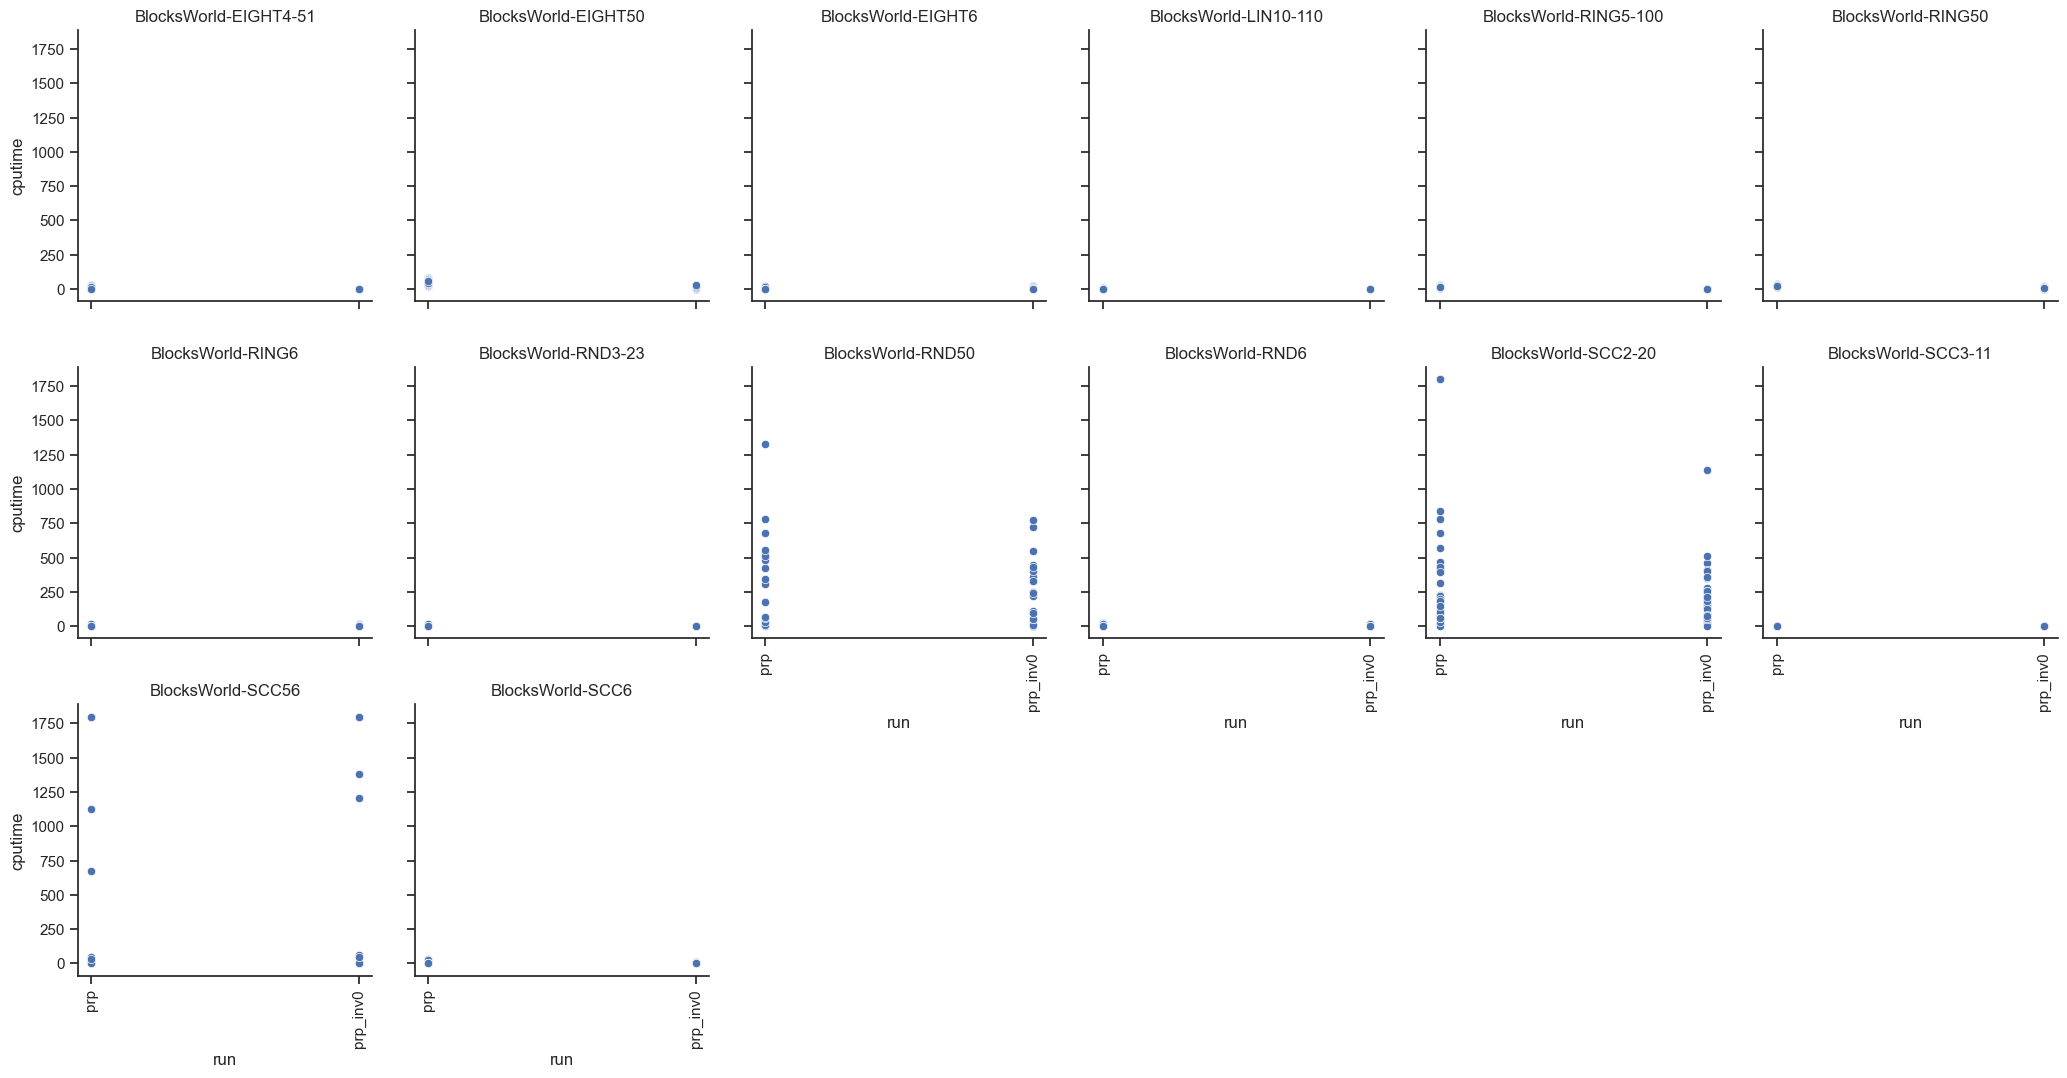

In [38]:
g = sns.relplot(data=df_sel, kind="scatter", x='run',  y="cputime", col="full_domain",  col_wrap=6, height=3.5, aspect=1, legend=True)
# g = sns.relplot(data=all_df, kind="scatter", x='run',  y="cputime", col="domain",  col_wrap=5, height=4, aspect=.8, legend=True, order=["lpg_large", "lpg_small", "prp_0", "prp_300", "prp2_0", "prp2_300"])

g.set_titles(template='{col_name}',y=1)

# rotate x-labels
x_labels = g.axes[-1].get_xticklabels() # get x labels of last plot in grid (must have the labels!)
g.set_xticklabels(labels=x_labels, rotation=90)

### Time-Coverage chart for a SINGLE full domain (as in R)

In [39]:
# select full domain to consider
full_domain = "Barman-EIGHT50"

In [40]:
def compute_coverage(df: pd.DataFrame) -> pd.DataFrame:
    # columns to group-by
    selection_index = ['run', 'domain', 'sub_domain', 'full_domain']

    # count normalized (0-1) the number of grade after grouping for all the other values
    coverage_df = df.groupby(by=selection_index)["solved"].value_counts(normalize=True)

    # transofm the serie into a dataframe and value becomes percent
    coverage_df = coverage_df.mul(100).rename('percent').reset_index()


    # convert the rows that have 100% unsovable (False), to 0% solvable (True)
    #   otherwise, there will be no True solvable for those cases!
    mask_unsolvable = (~coverage_df.solved) & (coverage_df.percent == 100)
    coverage_df.loc[mask_unsolvable, ["solved", "percent"]] = [True, 0]

    # return the % of solvable stats 
    return coverage_df.loc[coverage_df.solved].round(0)

compute_coverage(df)


,run,domain,sub_domain,full_domain,solved,percent
0,lpg,Airport,,Airport-,True,75.0
3,lpg,Barman,EIGHT50,Barman-EIGHT50,True,50.0
4,lpg,Barman,RING50,Barman-RING50,True,95.0
7,lpg,Barman,RND50,Barman-RND50,True,25.0
9,lpg,Barman,SCC56,Barman-SCC56,True,10.0
...,...,...,...,...,...,...
601,prp_inv0,ZenoTravel,RND54,ZenoTravel-RND54,True,80.0
604,prp_inv0,ZenoTravel,SCC2-20,ZenoTravel-SCC2-20,True,48.0
606,prp_inv0,ZenoTravel,SCC3-11,ZenoTravel-SCC3-11,True,33.0
608,prp_inv0,ZenoTravel,SCC56,ZenoTravel-SCC56,True,38.0


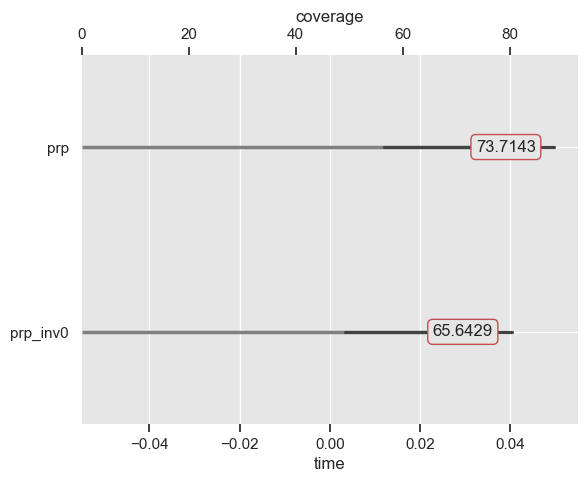

In [41]:
# https://seaborn.pydata.org/tutorial/aesthetics.html
# https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme()  
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots()

# FIRST graph for cputime per solver only on solved instances
sns.set_style("darkgrid")
g = sns.scatterplot(data=df_sel.query("solved and full_domain == @full_domain"), x='cputime', y='run', ax=ax)
g.set_xlabel("time")


# SECOND overlapped graph for coverage per solver
sns.set_style("ticks")  # just ticks, no grid
ax2 = ax.twiny()    # get a twin y-axies https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
g = sns.barplot(
    data=compute_coverage(df_sel).round(0),
    x="percent",
    y="run",
    width=0.0001,
    linewidth=2.5,
    edgecolor=".5",
    facecolor=(0, 0, 0, 0),
    ax=ax2,
)
g.set_xlabel('coverage')

# Coverage % in a rounded box at the end of the bar
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar_label.html
# https://matplotlib.org/stable/api/text_api.html#matplotlib.text.Text
bbox = dict(boxstyle="round", fc="0.9", fill=True, color='r') # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html#matplotlib.patches.FancyBboxPatch
ax2.bar_label(ax2.containers[0], padding=0, label_type='edge', fontweight='normal', mouseover=True, rotation="horizontal", bbox=bbox)


# changes the first bar itself
# https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle
# ax2.containers[0].patches[0].set(linewidth=10)

# FINAL touches
sns.despine(left=True, bottom=True) # no spines at all

plt.show()

## 3. Time-coverage charts for ALL full domains in selected set benchmark

First get the set of interest:

In [42]:
print("Runs available:", df["run"].unique())

RUNS = ["prp", "prp_inv0", "lpg", "lpg_small"]
df_sel = df.loc[(df.set == SET) & (df.run.isin(RUNS))]
df_sel.head()

Runs available: ['pr2' 'pr2_inv0' 'prp' 'prp_inv0' 'lpg' 'lpg_small']


,task,run,status,solved,cputime,walltime,memory_mb,policy_size,solve_time,translation_time,benchmark,set,domain,sub_domain,full_domain,instance
4540,FOND_BlocksWorld_EIGHT4-51_10.yml,prp,true,True,2.329041,2.350352,48.021504,75.0,1.919890,0.254818,"(FOND, BlocksWorld, EIGHT4-51, 10)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,10
4541,FOND_BlocksWorld_EIGHT4-51_13.yml,prp,true,True,4.889040,4.909981,55.767040,86.0,4.484820,0.251215,"(FOND, BlocksWorld, EIGHT4-51, 13)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,13
4542,FOND_BlocksWorld_EIGHT4-51_16.yml,prp,true,True,7.593550,7.614505,59.252736,95.0,7.194445,0.246724,"(FOND, BlocksWorld, EIGHT4-51, 16)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,16
4543,FOND_BlocksWorld_EIGHT4-51_19.yml,prp,true,True,11.171908,11.193337,75.714560,141.0,10.765883,0.255271,"(FOND, BlocksWorld, EIGHT4-51, 19)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,19
4544,FOND_BlocksWorld_EIGHT4-51_22.yml,prp,true,True,19.731542,19.755172,131.846144,171.0,19.324429,0.257484,"(FOND, BlocksWorld, EIGHT4-51, 22)",FOND,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,22


Count how MANY instances per full domain:

In [43]:
selection_index = ['full_domain']

# count the number of each run per full_domain (e.g., how many lpg runs in Barman-EIGHT50)
count_df = df_sel.groupby(by=selection_index)['run'].value_counts()

count_df = count_df.reset_index()

# # transofm the serie into a dataframe and value becomes percent
# coverage_df = coverage_df.mul(100).round(0).rename('percent').reset_index()
# coverage_df = coverage_df.loc[coverage_df.status].reset_index(drop=True)    # keep just the TRUE status (solved!)

count_df  
# count_df.query("full_domain == 'Logistics-TRICKY-RING' or full_domain == 'Logistics-SCC56'")

,full_domain,run,count
0,BlocksWorld-EIGHT4-51,prp,17
1,BlocksWorld-EIGHT4-51,prp_inv0,17
2,BlocksWorld-EIGHT50,prp,20
3,BlocksWorld-EIGHT50,prp_inv0,20
4,BlocksWorld-EIGHT6,prp,23
5,BlocksWorld-EIGHT6,prp_inv0,23
6,BlocksWorld-LIN10-110,prp,21
7,BlocksWorld-LIN10-110,prp_inv0,21
8,BlocksWorld-RING5-100,prp,20
9,BlocksWorld-RING5-100,prp_inv0,20


Next calculate coverage for each solver run in each full domain:

In [44]:
# # merge with count of instances per full domain
coverage_df = compute_coverage(df_sel)
coverage_df = coverage_df.merge(count_df)
coverage_df

# SOME FILTERS
# coverage_df.query("not solved and percent == 100")
# coverage_df.query("solved and percent == 0")

,run,domain,sub_domain,full_domain,solved,percent,count
0,prp,BlocksWorld,EIGHT4-51,BlocksWorld-EIGHT4-51,True,100.0,17
1,prp,BlocksWorld,EIGHT50,BlocksWorld-EIGHT50,True,50.0,20
2,prp,BlocksWorld,EIGHT6,BlocksWorld-EIGHT6,True,100.0,23
3,prp,BlocksWorld,LIN10-110,BlocksWorld-LIN10-110,True,86.0,21
4,prp,BlocksWorld,RING5-100,BlocksWorld-RING5-100,True,100.0,20
5,prp,BlocksWorld,RING50,BlocksWorld-RING50,True,70.0,20
6,prp,BlocksWorld,RING6,BlocksWorld-RING6,True,100.0,23
7,prp,BlocksWorld,RND3-23,BlocksWorld-RND3-23,True,90.0,21
8,prp,BlocksWorld,RND50,BlocksWorld-RND50,True,50.0,20
9,prp,BlocksWorld,RND6,BlocksWorld-RND6,True,65.0,23


Let's check the coverage in a particular full domain:

In [45]:
import random

x = random.choice(coverage_df['full_domain'].unique())
coverage_df.loc[coverage_df.full_domain == x]

,run,domain,sub_domain,full_domain,solved,percent,count
7,prp,BlocksWorld,RND3-23,BlocksWorld-RND3-23,True,90.0,21
21,prp_inv0,BlocksWorld,RND3-23,BlocksWorld-RND3-23,True,90.0,21


Some useful links to make nice charts:

* [Changing plot style and color](https://s3.amazonaws.com/assets.datacamp.com/production/course_15192/slides/chapter4.pdf).
* [Advanced Seaborn: Demystifying the Complex Plots!](https://levelup.gitconnected.com/advanced-seaborn-demystifying-the-complex-plots-537582977c8c#5965 )

OK this is the main code for drawing complex combined time-coverage charts across a full set benchmark (e.g., AIJ) as done with the R's script. 

For each full domain (e.g., Barman-EIGHT50), draw a plot showing scatter time performance across instances per solver/run AND coverage bars superimposed. This was Nitin's great graphs done originally in R for ECAI'23.

In each subplot, the title shows the full domain with the number of instances run (e.g., "Barman-EIGHT50 (20)": 20 instances run for Barman-EIGHT50 full domain).

Finished building scattered plot of cputime. Next overlapping coverage bars...


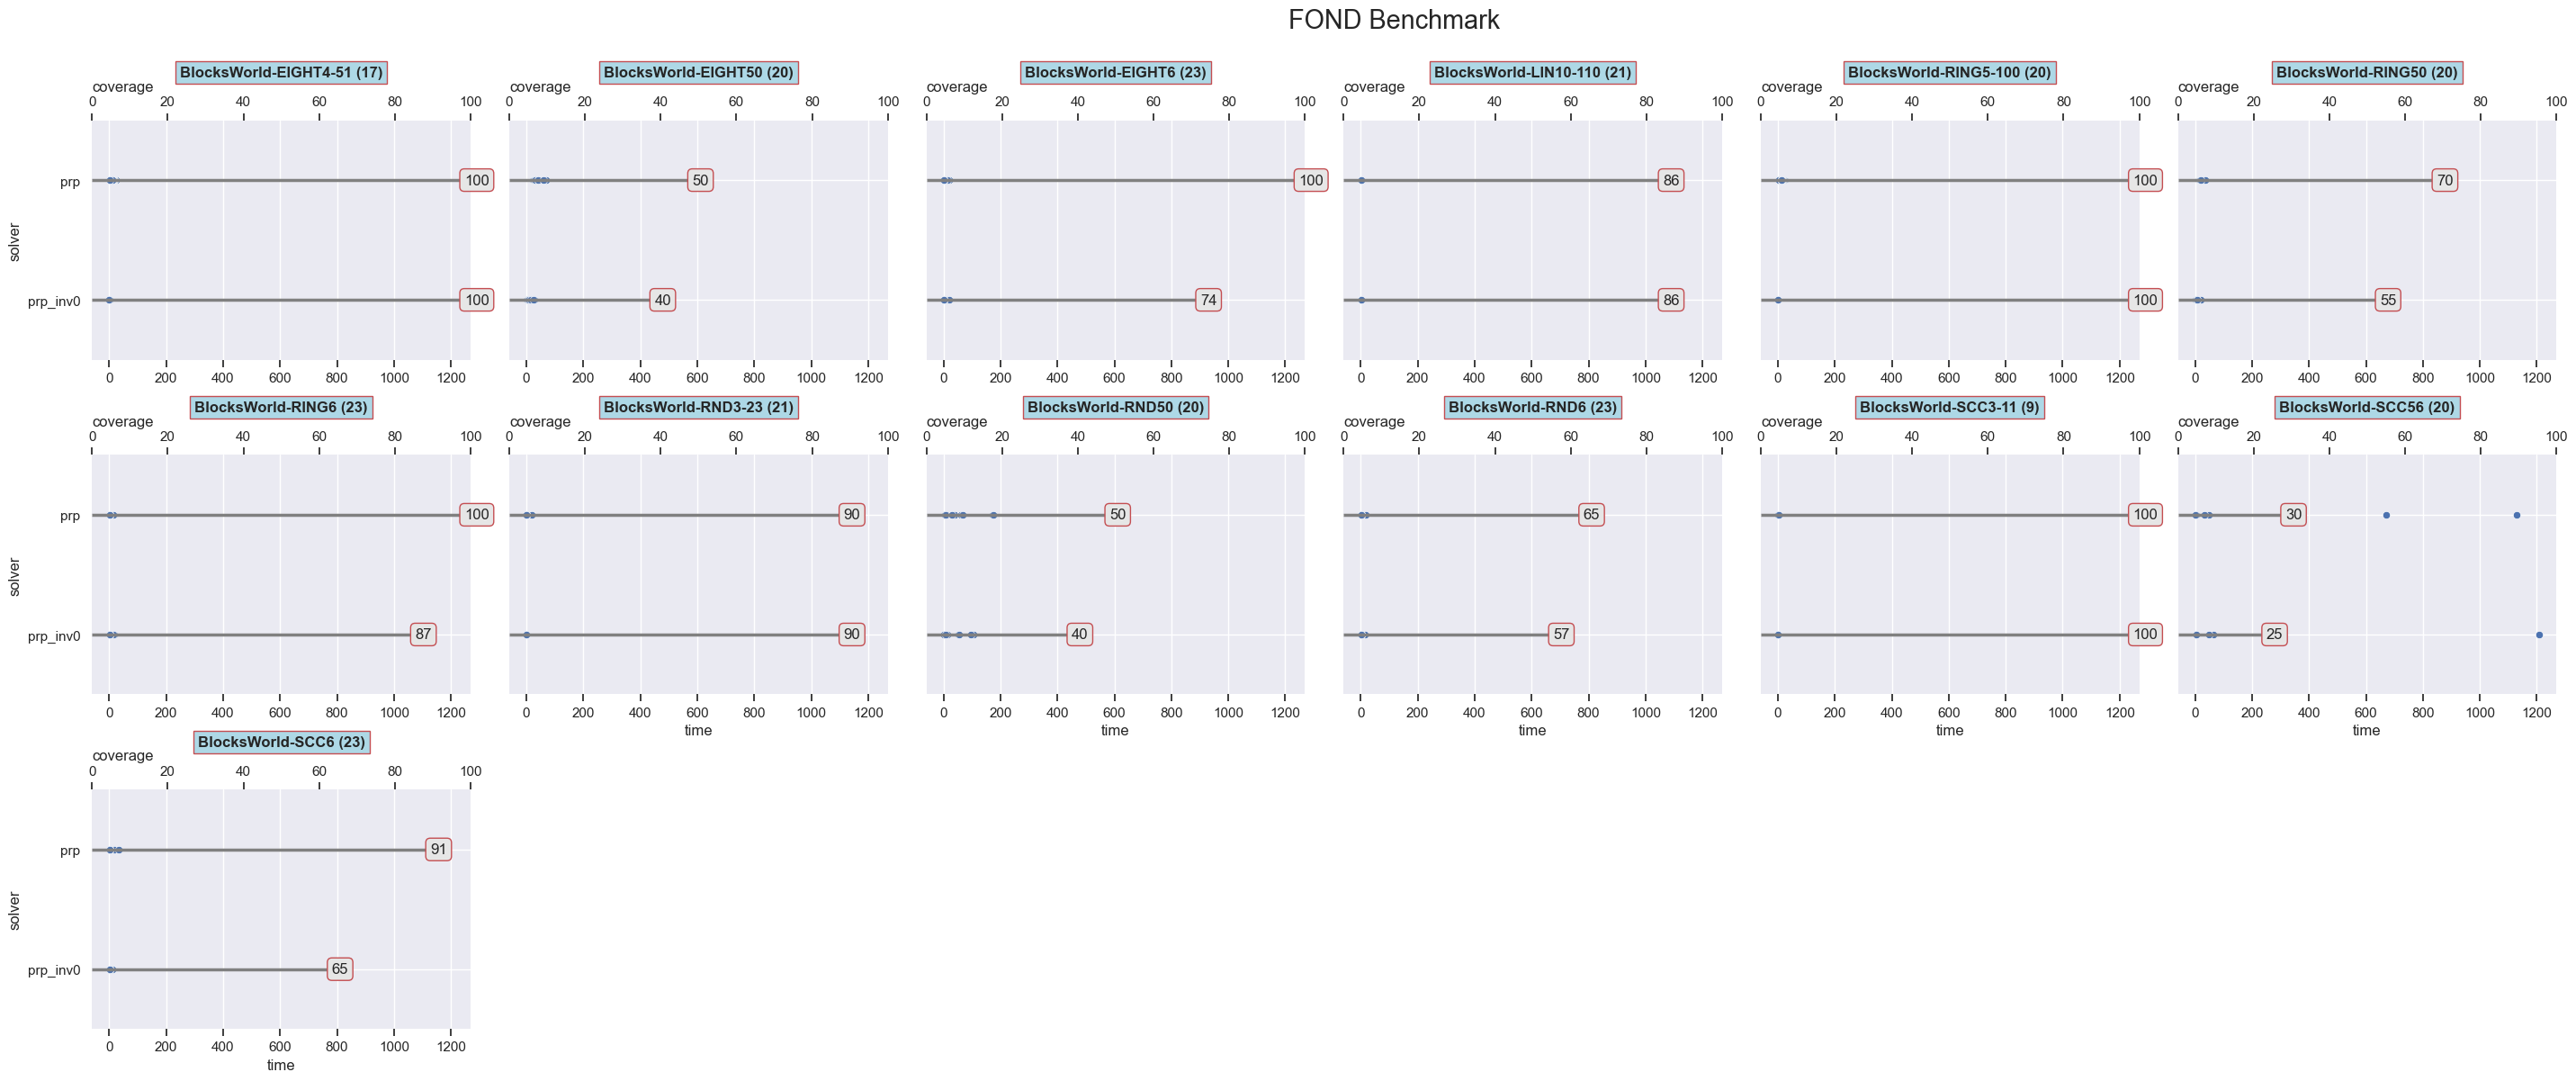

In [46]:
# https://seaborn.pydata.org/tutorial/aesthetics.html
# https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme()

# fig, ax = plt.subplots()

# FIRST graph for cputime per solver
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("darkgrid")

# box for the title of each subplot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html#matplotlib.patches.FancyBboxPatch
bbox1 = dict(boxstyle="square", fc="lightblue", fill=True, color='r')
bbox2 = dict(boxstyle="round", fc="0.9", fill=True, color='r')


## FIRST, we do a scatter plot for each full domain showing cputime for each solved instance across each solver/run
# https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot
g = sns.relplot(data=df_sel.query('solved'), kind="scatter", x='cputime', y='run', col="full_domain", col_wrap=6, height=4, aspect=1.2)
g.set_axis_labels("time", "solver")
# Let's configure the title of each subplot
#   most options are passed to text: https://matplotlib.org/stable/api/text_api.html
g.set_titles(col_template='{col_name}', fontweight="demibold",  ha='center', va='center', bbox=bbox1)

# get the whole figure title: XXX Benchmark
g.figure.suptitle(
    f"{SET} Benchmark", ha="left", va="top", fontsize="xx-large", y=1
)  # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html


print("Finished building scattered plot of cputime. Next overlapping coverage bars...")

# get all the axes (subplots) of the FaceGrid
axes = g.axes.flatten()

## SECOND, super-impose the COVERAGE data in each subplot in the grid as done in https://stackoverflow.com/a/67612124
#   we also rename the title of each subplot to include no of instances run
#   we iterate on each axis and plot a barplot and add annotations/styles to it
sns.set_style("ticks")  # just ticks, no grid
for ax in axes:
    # full_domian = ax.get_title().split(' = ')[1]
    full_domain = ax.get_title()

    # redo title of subfigure to include number of instances between parenthesis, e.g., BARMAN-EIGHT50 (20)
    no_instances = coverage_df.loc[coverage_df.full_domain == ax.get_title()]['count'].unique()[0]
    ax.set_title(f"{full_domain} ({no_instances})", fontweight="demibold",  ha='center', va='center', bbox=bbox1)

    # add bar of coverage % for each run/solver
    ax2 = ax.twiny()    # get a twin y-axies https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
    g2 = sns.barplot(data=coverage_df[coverage_df.full_domain.eq(full_domain)], x="percent", y="run", width=0.0001, linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0), ax=ax2)
    g2.set_xlabel('coverage', x=0, ha="left")
    g2.set_xlim([0, 100])

    # add box with % of coverage at the end of the barline
    if len(ax2.containers) > 0 :
        ax2.bar_label(ax2.containers[0], label_type='edge', padding=-5, fontweight='normal', rotation="horizontal", bbox=bbox2)


# axes[0].legend().remove()
# g.set_axis_labels(x_var=None, y_var=None, clear_inner=True)
sns.despine(left=True, bottom=True) # no spines at all

# Save it later, not here.
# plt.savefig(os.path.join(CSV_FOLDER, f"{SET}_plot.png"))

plt.tight_layout()  # at the end adjust so everything fits tight but well
plt.show()

Save graph in a PNG file:

In [47]:
g.savefig(os.path.join(CSV_FOLDER, f"{SET}_plot.png"))

## 4. Coverage Analysis

We now generate **coverage** tables, as they often apper in papers. Basically we compute per benchmark set, domain, and APP type sub-domain, and each solver-run:

- **Coverage:** % of solved instances solved by the solver-run; and
- **Stat metrics:** mean on time, memory usage, and policy size.

In [22]:
df = pd.read_csv(os.path.join(CSV_FOLDER,"results_all.csv"))

print(df.shape)
df.head()

(9080, 16)


,task,run,status,solved,cputime,walltime,memory_mb,policy_size,solve_time,translation_time,benchmark,set,domain,sub_domain,full_domain,instance
0,AIJ_Barman_EIGHT50_1.yml,pr2,true,True,16.026175,16.066372,123.805696,1370.0,15.562511,0.303117,"('AIJ', 'Barman', 'EIGHT50', '1')",AIJ,Barman,EIGHT50,Barman-EIGHT50,1
1,AIJ_Barman_EIGHT50_10.yml,pr2,true,True,15.246974,15.289514,112.234496,3672.0,14.780735,0.306904,"('AIJ', 'Barman', 'EIGHT50', '10')",AIJ,Barman,EIGHT50,Barman-EIGHT50,10
2,AIJ_Barman_EIGHT50_11.yml,pr2,true,True,68.218810,68.266702,121.892864,19793.0,67.748034,0.316544,"('AIJ', 'Barman', 'EIGHT50', '11')",AIJ,Barman,EIGHT50,Barman-EIGHT50,11
3,AIJ_Barman_EIGHT50_12.yml,pr2,true,True,104.457013,104.491214,142.397440,23262.0,103.991306,0.297826,"('AIJ', 'Barman', 'EIGHT50', '12')",AIJ,Barman,EIGHT50,Barman-EIGHT50,12
4,AIJ_Barman_EIGHT50_13.yml,pr2,true,True,114.354010,114.391022,159.453184,31096.0,113.890758,0.301574,"('AIJ', 'Barman', 'EIGHT50', '13')",AIJ,Barman,EIGHT50,Barman-EIGHT50,13


Calculate % ratio per set/domain/sub_domain/run-solver.

In [23]:
df_grouped = df.groupby(["set", "domain", "sub_domain", "run"])

#   df_grouped.sum()[["solved"]] = sum all the True instances (sum over bool = number of True)
#   df_grouped.count()[["solved"]] = number of rows in solved column (includes True and Talse values)
df_coverage = df_grouped.sum()[["solved"]] / df_grouped.count()[["solved"]]
df_coverage

solved
set  domain     sub_domain run              
AIJ  Barman     EIGHT50    lpg          0.50
                           lpg_small    1.00
                           pr2          1.00
                           pr2_inv0     1.00
                           prp          1.00
...                                      ...
SOCS ZenoTravel STL5-43    lpg_small    0.15
                           pr2          0.10
                           pr2_inv0     0.10
                           prp          0.20
                           prp_inv0     0.20

[416 rows x 1 columns]

Calculate mean metric (for CPU time, memory, and policy size) across the solved instances.

In [24]:
columns = ["domain", "sub_domain", "run", "cputime", "memory_mb", "policy_size"]
df_solved = df.query("solved == True")[columns]

df_solved_grouped = df_solved.groupby(["domain", "sub_domain", "run"])
df_metrics = df_solved_grouped.mean()
df_metrics

cputime   memory_mb  policy_size
domain     sub_domain run                                           
Barman     EIGHT50    lpg        471.474683  319.318835     24468.70
                      lpg_small  125.349837  298.358374     13018.35
                      pr2         39.494547  144.115098      7096.90
                      pr2_inv0   137.454684  127.855411     14486.00
                      prp        107.039009  263.197901      1854.60
...                                     ...         ...          ...
ZenoTravel STL5-43    lpg_small   82.453476  304.563541       149.00
                      pr2          0.805594   38.445056        63.00
                      pr2_inv0     0.789391   38.457344        66.00
                      prp        242.246380  185.327616        94.00
                      prp_inv0     3.222715   36.191232       116.75

[300 rows x 3 columns]

Put together **Coverage** and **Metrics** tables.

In [25]:
column_names = {
    "solved": "cov",
    "cputime": "time",
    "memory_mb": "mem",
    "policy_size": "size",
}

df_stats = df_coverage.join(df_metrics, how="inner")
df_stats.rename(columns=column_names, inplace=True)

df_stats = df_stats.reset_index()
df_stats.insert(0, "set", df_stats.pop("set"))

df_stats

,set,domain,sub_domain,run,cov,time,mem,size
0,AIJ,Barman,EIGHT50,lpg,0.50,471.474683,319.318835,24468.70
1,AIJ,Barman,EIGHT50,lpg_small,1.00,125.349837,298.358374,13018.35
2,AIJ,Barman,EIGHT50,pr2,1.00,39.494547,144.115098,7096.90
3,AIJ,Barman,EIGHT50,pr2_inv0,1.00,137.454684,127.855411,14486.00
4,AIJ,Barman,EIGHT50,prp,1.00,107.039009,263.197901,1854.60
...,...,...,...,...,...,...,...,...
369,SOCS,ZenoTravel,STL5-43,lpg_small,0.15,82.453476,304.563541,149.00
370,SOCS,ZenoTravel,STL5-43,pr2,0.10,0.805594,38.445056,63.00
371,SOCS,ZenoTravel,STL5-43,pr2_inv0,0.10,0.789391,38.457344,66.00
372,SOCS,ZenoTravel,STL5-43,prp,0.20,242.246380,185.327616,94.00


In [26]:
df_stats_pivot = df_stats.pivot(
    index=["set", "domain", "sub_domain"],
    values=["cov", "time", "mem", "size"],
    columns="run",
)
df_stats_pivot.reset_index(
    inplace=True
)  # unfold multi-index into columns (create integer index)
df_stats_pivot.columns = [
    "_".join(tup).rstrip("_") for tup in df_stats_pivot.columns.values
]

# flat index, but multi-column: 1. coverage / time / policy size and 2. each solver/run
df_stats_pivot = df_stats_pivot.round(2)

df_stats_pivot

,set,domain,sub_domain,cov_lpg,cov_lpg_small,cov_pr2,cov_pr2_inv0,cov_prp,cov_prp_inv0,time_lpg,...,mem_pr2,mem_pr2_inv0,mem_prp,mem_prp_inv0,size_lpg,size_lpg_small,size_pr2,size_pr2_inv0,size_prp,size_prp_inv0
0,AIJ,Barman,EIGHT50,0.50,1.00,1.00,1.00,1.00,0.80,471.47,...,144.12,127.86,263.20,61.92,24468.70,13018.35,7096.90,14486.00,1854.60,2400.00
1,AIJ,Barman,RING50,0.95,1.00,1.00,1.00,1.00,1.00,166.52,...,247.45,51.01,242.62,41.55,1829.63,1858.75,631.85,941.30,665.75,1022.55
2,AIJ,Barman,RND50,0.25,0.55,0.75,0.75,0.70,0.45,439.73,...,84.67,175.98,119.67,148.26,28568.20,34688.64,6701.20,22645.33,2788.21,3852.22
3,AIJ,Barman,SCC56,0.10,0.35,0.75,0.35,0.60,0.25,527.75,...,104.64,158.56,103.62,45.15,37293.50,24015.71,15002.07,19546.43,3484.25,2297.60
4,AIJ,BlocksWorld,EIGHT4-51,1.00,1.00,1.00,1.00,1.00,1.00,61.65,...,196.43,39.06,175.76,33.55,98.82,106.53,233.65,233.53,207.94,208.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,SOCS,ZenoTravel,RND3-23,0.15,0.10,0.10,0.10,0.45,0.30,345.94,...,38.03,37.99,208.79,226.04,168.00,192.50,320.00,325.50,2198.56,1119.50
66,SOCS,ZenoTravel,RND54,0.80,0.65,0.25,0.35,0.90,0.80,381.10,...,145.06,117.12,672.67,671.25,3940.56,6886.69,5575.00,2833.14,5957.83,5749.94
67,SOCS,ZenoTravel,SCC3-11,0.11,0.11,0.11,NaN,0.33,0.33,947.38,...,93.75,NaN,66.85,117.60,275.00,186.00,419.00,NaN,1318.67,1316.67
68,SOCS,ZenoTravel,SCC56,0.35,0.25,0.05,0.05,0.50,0.40,322.76,...,112.90,115.13,539.99,674.28,4713.96,6285.36,7389.00,8313.00,10994.55,11026.93


Save it to the file, this can be used if needed elsewhere

In [117]:
df_stats_pivot.to_csv(os.path.join(CSV_FOLDER, "results_stats.csv"), index=False)